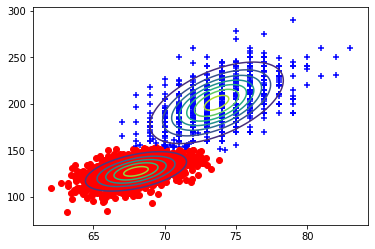

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from gmm.algorithm import GMM
from gmm.algorithm import GMM

# Read in dataset from file
#with open('examples/faithful.txt', 'rt') as f:
#    data = []
#    for row in f:
#        cols = row.strip('\r\n').split(' ')
#        data.append(np.fromiter(map(lambda x: float(x), cols), np.float))
#    data = np.array(data)
data = np.loadtxt('examples/humanData.txt')[:,:-1]
# Initialize GMM algorithm
n_components = 2
gmm_model = GMM(n_components)

# Fit GMM to the data
gmm_model.fit(data)

# Cluster data
labelled = gmm_model.cluster(data)

# Plot clustered data with the location of Gaussian mixtures
plt.figure()

# Plot contours of Gaussian mixtures
for mean, cov in zip(gmm_model.means, gmm_model.covariances):
    # Create grid
    mean_x = mean[0]
    std_x = np.sqrt(cov[0][0])
    mean_y = mean[1]
    std_y = np.sqrt(cov[1][1])
    x = np.linspace(mean_x - 3*std_x, mean_x + 3*std_x, 100)
    y = np.linspace(mean_y - 3*std_y, mean_y + 3*std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Tabulate pdf values
    Z = np.empty(X.shape, np.float)

    for i in np.arange(X.shape[0]):
        for j in np.arange(X.shape[1]):
            v = np.array([X[i][j], Y[i][j]])
            Z[i][j] = gmm_model.multivariate_normal_pdf(v, mean, cov)

    # Plot contours
    plt.contour(X, Y, Z)

# Plot features assigned to each Gaussian mixture
markers = ['o', '+']
colors = ['r', 'b']
for d, l in zip(data, labelled):
    plt.scatter(d[0], d[1], color=colors[l], marker=markers[l])
plt.savefig('scatter_plot.pdf')


Dataset shape: (2234, 2)
[[133.1423  66.6682]
 [234.      68.8986]]
[0.5 0.5]
(2, 2, 2)


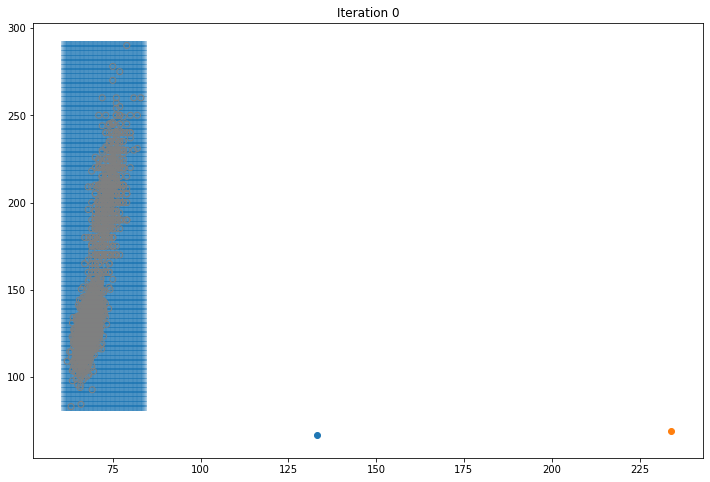

LinAlgError: singular matrix

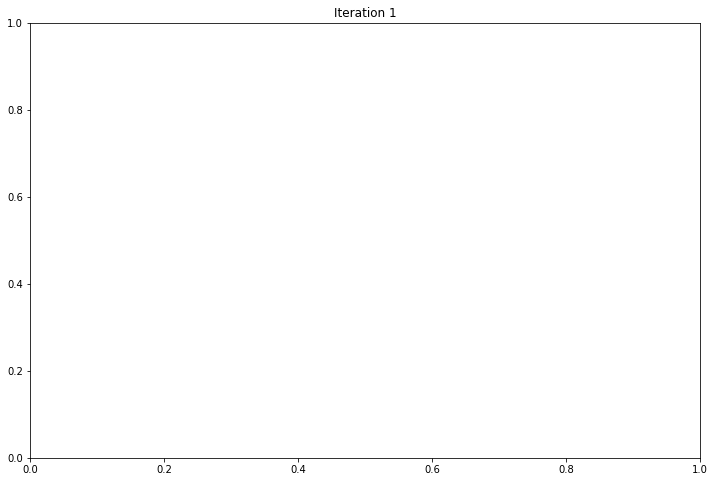

In [48]:

import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
plt.rcParams["axes.grid"] = False

# define the number of samples to be drawn
n_samples = 100

# define the mean points for each of the systhetic cluster centers
t_means = [[67,120], [75,200]]

# for each cluster center, create a Positive semidefinite convariance matrix
t_covs = []
for s in range(len(t_means)):
  t_covs.append(make_spd_matrix(2))

#X = []
#for mean, cov in zip(t_means,t_covs):
#  x = np.random.multivariate_normal(mean, cov, n_samples)
#  X += list(x)
  
X = data
np.random.shuffle(X)
print("Dataset shape:", X.shape)

# Create a grid for visualization purposes 
#x = np.linspace(np.min(X[...,0])-1,np.max(X[...,0])+1,100)
#y = np.linspace(np.min(X[...,1])-1,np.max(X[...,1])+1,80)
#X_,Y_ = np.meshgrid(x,y)
#pos = np.array([X_.flatten(),Y_.flatten()]).T
#print(pos.shape)
#print(np.max(pos[...,1]))

# define the number of clusters to be learned
k = 2

# create and initialize the cluster centers and the weight paramters
weights = np.ones((k)) / k
means = np.random.choice(X.flatten(), (k,X.shape[1]))
print(means)
print(weights)

# create and initialize a Positive semidefinite convariance matrix 
cov = []
for i in range(k):
  cov.append(make_spd_matrix(X.shape[1]))
cov = np.array(cov)
print(cov.shape)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'magenta', 'yellow', 'red', 'brown', 'grey']
eps=1e-8

# run GMM for 40 steps
for step in range(40):

  # visualize the learned clusters
  if step % 1 == 0:
    plt.figure(figsize=(12,int(8)))
    plt.title("Iteration {}".format(step))
    axes = plt.gca()
    
    likelihood = []
    for j in range(k):
      likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)
    
    for c in range(k):
      pred_ids = np.where(predictions == c)
      plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')
    
    plt.scatter(X[...,0], X[...,1], facecolors='none', edgecolors='grey')
    
    for j in range(k):
      plt.scatter(means[j][0], means[j][1], color=colors[j])

    #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()

  likelihood = []
  # Expectation step
  for j in range(k):
    likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
  likelihood = np.array(likelihood)
  assert likelihood.shape == (k, len(X))
    
  b = []
  # Maximization step 
  for j in range(k):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

    # updage mean and variance
    means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
    cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)

    # update the weights
    weights[j] = np.mean(b[j])
    
    assert cov.shape == (k, X.shape[1], X.shape[1])
    assert means.shape == (k, X.shape[1])

# !sudo apt-get update
# !sudo apt-get install ffmpeg imagemagick
# !convert -delay 35 -loop 0 *.png out_.gif



In [6]:

## GMM functions 

#calculate the initial covariance matrix
#covType: diag, full
def getInitialsGMM(X,k,covType):
    if covType == 'full':
        dataArray = np.transpose(np.array([pt[0:-1] for pt in X]))
        covMat = np.cov(dataArray)
    else:
        covMatList = []
        for i in range(len(X[0])-1):
            data = [pt[i] for pt in X]
            #print(data)
            cov = np.asscalar(np.cov(data))
            print(cov)
            covMatList.append(cov)
        covMat = np.diag(covMatList)

    initialClusters = {}
    for i in range(k):
        pass
    return covMat


def calcLogLikelihood(X,clusters,k):
    loglikelihood = 0
    #Your code here
    return loglikelihood

#E-step
def updateEStep(X,clusters,k):
    EMatrix = []
    #Your code here
    return EMatrix

#M-step
def updateMStep(X,clusters,EMatrix):
    pass
    return clusters

def visualizeClustersGMM(X,labels,clusters,covType):
    #Your code here
    pass

def gmmCluster(X, k, covType, maxIter=1000):
    #initial clusters
    clustersGMM = getInitialsGMM(X,k,covType)
    labels = []
    #Your code here
    visualizeClustersGMM(X,labels,clustersGMM,covType)
    return labels,clustersGMM


def purityGMM(X, clusters, labels):
    purities = []
    #Your code here
    return purities


data = np.loadtxt('examples/humanData.txt')[:, :-1]

data
getInitialsGMM(X = data,k = 2,covType = 'diag')
divs = int(np.floor(data.shape[0] / 2))
divs
features_split = [data[i:i+divs] for i in range(0, data.shape[0], divs)]
np.shape(features_split)
#Q7
#labels11,clustersGMM11 = gmmCluster(dataset1, 2, 'diag')
#labels12,clustersGMM12 = gmmCluster(dataset1, 2, 'full')

#Q8
#labels21,clustersGMM21 = gmmCluster(dataset2, 2, 'diag')
#labels22,clustersGMM22 = gmmCluster(dataset2, 2, 'full')

#Q9
#purities11 = purityGMM(dataset1, clustersGMM11, labels11)
#purities12 = purityGMM(dataset1, clustersGMM12, labels12)
#purities21 = purityGMM(dataset2, clustersGMM21, labels21)
#purities22 = purityGMM(dataset2, clustersGMM22, labels22)
getInitialsGMM(X = data,k = 2,covType = 'diag')


12.467856392085611
12.467856392085611


array([[12.46785639]])